# Полный анализ FIFA 2021: очистка, исследование и статистика

Этот ноутбук объединяет все этапы анализа данных по игрокам FIFA 2021:
- **1.Очистка данных**: Загрузка, приведение в порядок названий столбцов, преобразование типов, обработка пропусков и дубликатов, создание новых признаков.
- **2. Исследовательский анализ**: Фильтрация, сортировка, группировка данных и создание сводных таблиц для выявления ключевых закономерностей.
- **3. Статистический анализ**: Расчет описательных статистик, корреляционный анализ, проверка гипотез и визуализация данных.
- **4. Графический анализ**: Создание и сохранение детализированных диаграмм и графиков для визуального представления данных.

## 1. Очистка данных (data_cleaning.py)

In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams

warnings.filterwarnings('ignore')
plt.rcParams['font.family'] = ['DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")
rcParams['figure.figsize'] = (12, 8)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

try:
    df = pd.read_csv('players.csv', encoding='utf-8')
    print(f'Данные успешно загружены. Исходный размер: {df.shape}')
except Exception as e:
    print(f'Ошибка при загрузке файла: {e}')

Данные успешно загружены. Исходный размер: (18979, 77)


### 1.1. Преобразование названий столбцов и текстовых данных

In [2]:
df.columns = (df.columns
              .str.lower()
              .str.replace(' ', '_')
              .str.replace('-', '_')
              .str.replace('&', 'and')
              .str.replace('↓', '')
              .str.replace('/', '_')
              .str.replace('(', '')
              .str.replace(')', '')
              .str.strip('_'))

text_columns = df.select_dtypes(include=['object']).columns
for col in text_columns:
    if col not in ['id', 'playerurl', 'photourl', 'name', 'full_name']:
        df[col] = df[col].astype(str).str.lower().str.strip()

print("Столбцы и текстовые данные очищены и приведены к единому формату.")

Столбцы и текстовые данные очищены и приведены к единому формату.


### 1.2. Создание новых признаков и преобразование данных

In [3]:
if 'team_and_contract' in df.columns:
    def split_team_contract(value):
        if pd.isna(value) or value == 'nan':
            return pd.Series([np.nan, np.nan, np.nan])
        value = str(value).strip()
        lines = value.split('\n')
        if len(lines) >= 2:
            team = lines[0].strip()
            contract = lines[1].strip()
            if '~' in contract:
                years = contract.split('~')
                if len(years) == 2:
                    try:
                        start_year = int(years[0].strip())
                        end_year = int(years[1].strip())
                    except ValueError:
                        start_year = np.nan
                        end_year = np.nan
                    return pd.Series([team, start_year, end_year])
            return pd.Series([team, np.nan, np.nan])
        else:
            return pd.Series([value, np.nan, np.nan])
    
    df[['club_name', 'contract_start_year', 'contract_end_year']] = df['team_and_contract'].apply(split_team_contract)
    df = df.drop('team_and_contract', axis=1)
    print('Столбец team_and_contract разделен на club_name, contract_start_year, contract_end_year.')

Столбец team_and_contract разделен на club_name, contract_start_year, contract_end_year.


In [4]:
if 'positions' in df.columns:
    df['positions_formatted'] = df['positions'].astype(str).str.replace(' ', ',')
    print('Позиции преобразованы в столбец positions_formatted.')
if 'height' in df.columns:
    def convert_height(height_str):
        if pd.isna(height_str): return np.nan
        height_str = str(height_str).strip()
        if "'" in height_str:
            parts = height_str.replace('"', '').split("'")
            if len(parts) == 2:
                feet = int(parts[0])
                inches = int(parts[1]) if parts[1] else 0
                return feet * 30.48 + inches * 2.54
        return np.nan
    df['height_cm'] = df['height'].apply(convert_height)
    df = df.drop('height', axis=1)
    print('Рост преобразован в сантиметры.')
if 'weight' in df.columns:
    df['weight_kg'] = df['weight'].astype(str).str.extract('(\d+)').astype(float) * 0.453592
    df = df.drop('weight', axis=1)
    print('Вес преобразован в килограммы.')

Позиции преобразованы в столбец positions_formatted.
Рост преобразован в сантиметры.
Вес преобразован в килограммы.


### 1.3. Обработка пропусков, дубликатов и сохранение

In [5]:
for col in df.columns:
    if df[col].isnull().any():
        if df[col].dtype in ['float64', 'int64']:
            df[col].fillna(df[col].median(), inplace=True)
        else:
            df[col].fillna(df[col].mode()[0], inplace=True)
print('Пропущенные значения заполнены медианой или модой.')

df = df.drop_duplicates()
print(f'Дубликаты удалены.')

df.to_csv('players_cleaned.csv', index=False)
print(f"Очищенные данные сохранены в 'players_cleaned.csv'. Финальный размер: {df.shape}")

Пропущенные значения заполнены медианой или модой.
Дубликаты удалены.
Очищенные данные сохранены в 'players_cleaned.csv'. Финальный размер: (18978, 80)


## 2. Исследовательский анализ (EDA) (analiz-2.py)

In [6]:
try:
    df = pd.read_csv('players_cleaned.csv')
    print(f'Очищенные данные для EDA загружены. Размер: {df.shape}')
except FileNotFoundError:
    print('Файл players_cleaned.csv не найден.')
    df = None

Очищенные данные для EDA загружены. Размер: (18978, 80)


### 2.1. Фильтрация и сортировка

In [7]:
if df is not None:
    print("Игроки с рейтингом > 90:")
    print(df[df['ova'] > 90][['longname', 'age', 'ova', 'pot', 'nationality']].head())

    print("\nТоп-10 игроков по потенциалу:")
    print(df.sort_values('pot', ascending=False)[['longname', 'age', 'ova', 'pot', 'nationality']].head(10))

Игроки с рейтингом > 90:
                       longname  age  ova  pot nationality
0                  lionel messi   33   93   93   argentina
1  c. ronaldo dos santos aveiro   35   92   92    portugal
2                     jan oblak   27   91   93    slovenia
3               kevin de bruyne   29   91   91     belgium
4    neymar da silva santos jr.   28   91   91      brazil

Топ-10 игроков по потенциалу:
                             longname  age  ova  pot  nationality
6                       kylian mbappé   21   90   95       france
0                        lionel messi   33   93   93    argentina
28                       jadon sancho   20   87   93      england
2                           jan oblak   27   91   93     slovenia
383  vinícius josé de oliveira júnior   19   80   93       brazil
62                        kai havertz   21   85   93      germany
11              marc-andré ter stegen   28   90   93      germany
275               joão félix sequeira   20   81   93     portu

### 2.2. Сводные таблицы и группировка

In [8]:
if df is not None:
    print("Сводная таблица: Средний рейтинг и количество игроков по топ-10 национальностям:")
    pivot1 = df.pivot_table(values='ova', index='nationality', aggfunc=['mean', 'count'])
    pivot1.columns = ['Средний рейтинг', 'Количество игроков']
    print(pivot1.sort_values('Средний рейтинг', ascending=False).head(10).round(2))
    
    print("\nГруппировка: Статистика по возрастным группам:")
    df['age_group'] = pd.cut(df['age'], bins=[0, 20, 25, 30, 35, 100], labels=['До 20', '20-25', '25-30', '30-35', '35+'])
    age_group_stats = df.groupby('age_group').agg({'ova': ['mean', 'max'], 'pot': ['mean', 'max']}).round(2)
    print(age_group_stats)

Сводная таблица: Средний рейтинг и количество игроков по топ-10 национальностям:
                          Средний рейтинг  Количество игроков
nationality                                                  
tanzania                            76.00                   1
chad                                73.00                   1
central african republic            72.67                   3
mozambique                          72.00                   5
bermuda                             72.00                   1
armenia                             71.50                   4
egypt                               71.40                  30
new caledonia                       71.00                   1
libya                               71.00                   4
puerto rico                         71.00                   1

Группировка: Статистика по возрастным группам:
             ova        pot    
            mean max   mean max
age_group                      
До 20      59.22  87  73.31  93

## 3. Статистический анализ (statistical_analysis.py)

### 3.1. Основные статистические показатели

In [9]:
if df is not None:
    key_numeric_columns = [
        'age', 'ova', 'pot', 'height_cm', 'weight_kg', 'sprint_speed', 
        'dribbling', 'shot_power', 'short_passing', 'stamina', 'reactions'
    ]
    key_numeric_columns = [col for col in key_numeric_columns if col in df.columns]
    print("Основные статистические показатели по ключевым признакам:")
    print(df[key_numeric_columns].describe().round(2))

Основные статистические показатели по ключевым признакам:
            age       ova       pot  height_cm  weight_kg  sprint_speed  \
count  18978.00  18978.00  18978.00   18978.00   18978.00      18978.00   
mean      25.19     65.72     71.14     181.22      75.02         64.41   
std        4.71      6.97      6.11       6.82       7.07         14.64   
min       16.00     47.00     47.00     154.94      49.90         12.00   
25%       21.00     61.00     67.00     175.26      69.85         57.00   
50%       25.00     66.00     71.00     180.34      74.84         67.00   
75%       29.00     70.00     75.00     185.42      79.83         74.00   
max       53.00     93.00     95.00     205.74     110.22         96.00   

       dribbling  shot_power  short_passing   stamina  reactions  
count   18978.00    18978.00       18978.00  18978.00   18978.00  
mean       55.59       57.80          58.77     62.65      61.65  
std        18.76       13.31          14.52     15.80       9.07 

### 3.2. Корреляционный анализ

Топ-10 корреляций с общим рейтингом (ova):
ova            1.000
bov            0.987
reactions      0.867
base_stats     0.846
composure      0.703
pas            0.699
dri            0.655
pot            0.632
total_stats    0.621
power          0.573
phy            0.572
Name: ova, dtype: float64


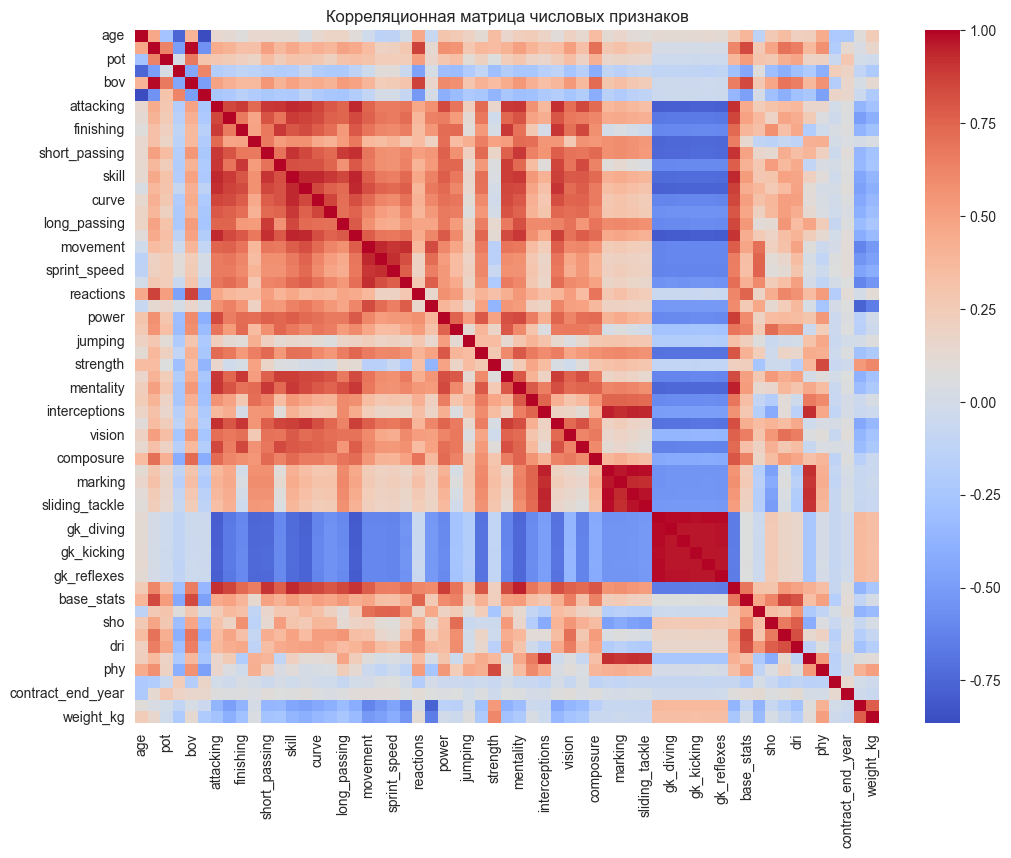

In [10]:
if df is not None:
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    corr_matrix = df[numeric_cols].corr()
    
    print("Топ-10 корреляций с общим рейтингом (ova):")
    ova_correlations = corr_matrix['ova'].sort_values(ascending=False)
    print(ova_correlations.head(11).round(3))
    
    plt.figure(figsize=(12, 9))
    sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
    plt.title('Корреляционная матрица числовых признаков')
    plt.show()

### 3.3. Визуализация распределений

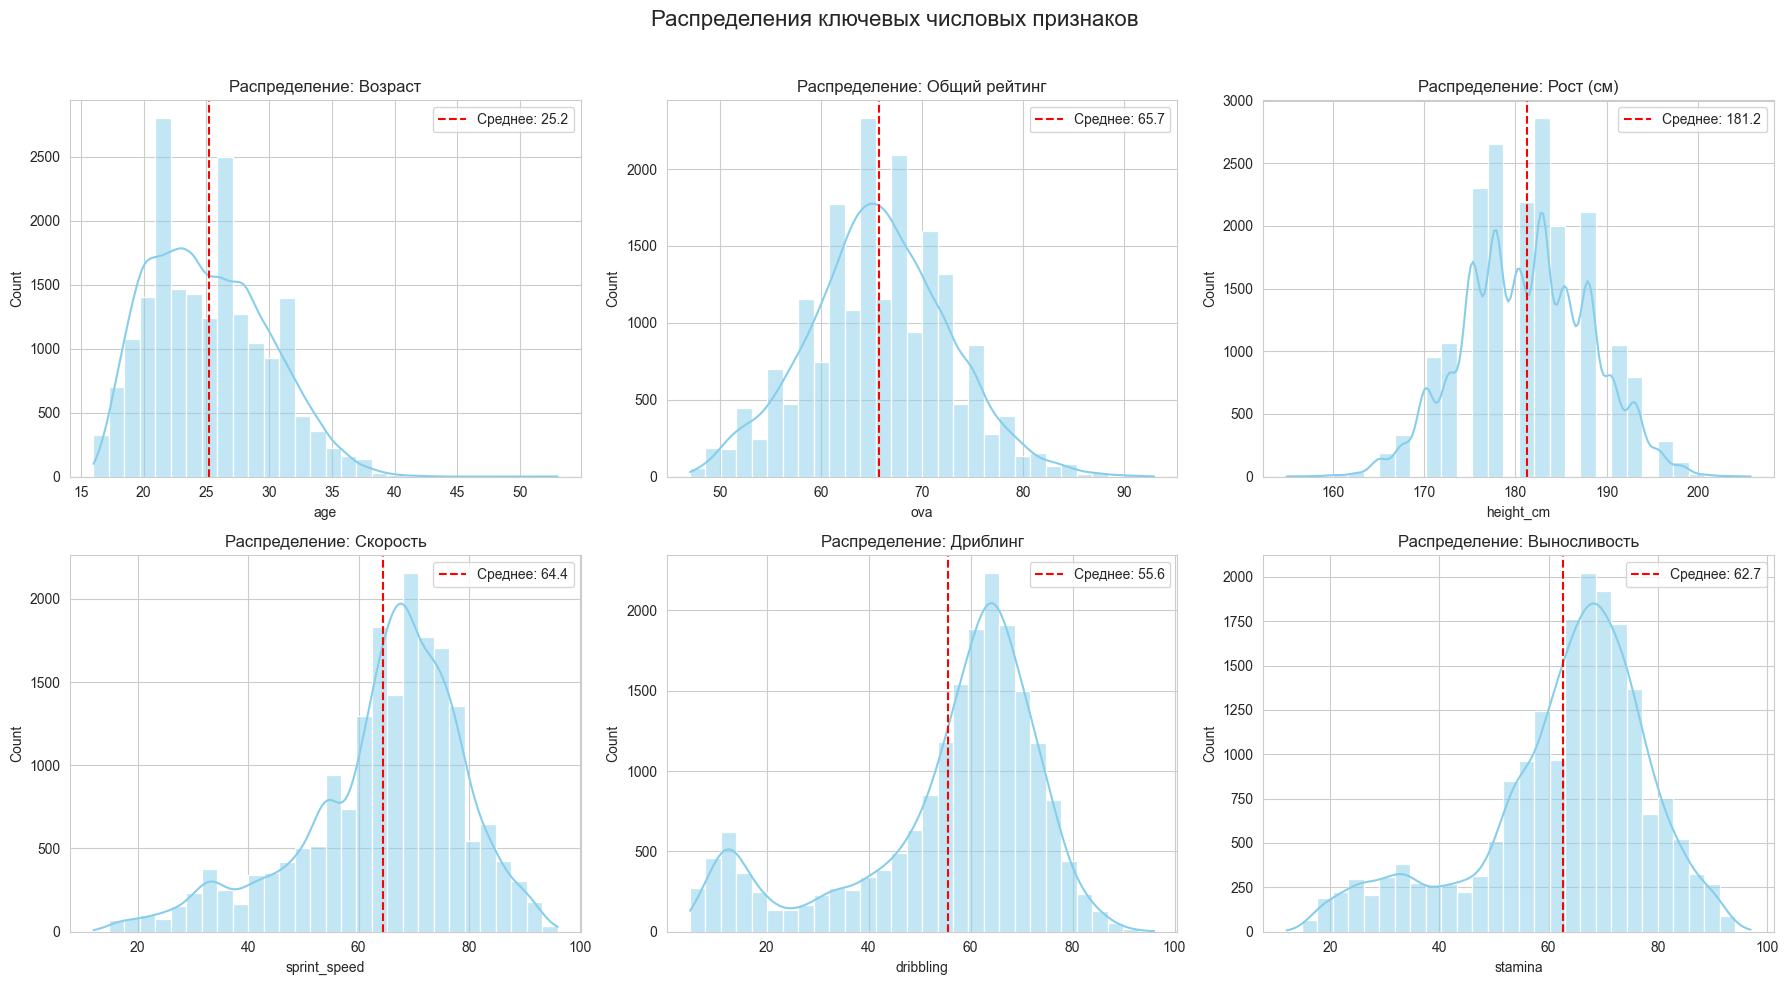

In [11]:
if df is not None:
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Распределения ключевых числовых признаков', fontsize=16)

    key_features = ['age', 'ova', 'height_cm', 'sprint_speed', 'dribbling', 'stamina']
    titles = ['Возраст', 'Общий рейтинг', 'Рост (см)', 'Скорость', 'Дриблинг', 'Выносливость']

    for i, (feature, title) in enumerate(zip(key_features, titles)):
        row, col = i // 3, i % 3
        sns.histplot(df[feature], bins=30, kde=True, ax=axes[row, col], color='skyblue')
        axes[row, col].set_title(f'Распределение: {title}')
        axes[row, col].axvline(df[feature].mean(), color='red', linestyle='--', label=f'Среднее: {df[feature].mean():.1f}')
        axes[row, col].legend()

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

### 3.4. Проверка статистических гипотез

In [12]:
from scipy.stats import ttest_ind, chi2_contingency

if df is not None:
    # Гипотеза 1: Средний рейтинг молодых игроков (до 25 лет) отличается от опытных (25+)
    young_players = df[df['age'] < 25]['ova']
    experienced_players = df[df['age'] >= 25]['ova']
    t_stat, p_value = ttest_ind(young_players, experienced_players)
    print(f"Т-тест (рейтинг молодых vs опытных): t-статистика = {t_stat:.2f}, p-значение = {p_value:.5f}")
    if p_value < 0.05:
        print("Результат: Отклоняем нулевую гипотезу. Средние рейтинги статистически значимо различаются.")
    else:
        print("Результат: Не отклоняем нулевую гипотезу.")

    # Гипотеза 2: Возраст и рейтинг являются зависимыми переменными
    df['age_group'] = pd.cut(df['age'], bins=[0, 20, 25, 30, 35, 100], labels=['До 20', '20-25', '25-30', '30-35', '35+'])
    df['rating_group'] = pd.cut(df['ova'], bins=[0, 60, 70, 80, 85, 100], labels=['До 60', '60-70', '70-80', '80-85', '85+'])
    contingency_table = pd.crosstab(df['age_group'], df['rating_group'])
    chi2, p_val, dof, expected = chi2_contingency(contingency_table)
    print(f"\nХи-квадрат тест (возраст и рейтинг): chi2 = {chi2:.2f}, p-значение = {p_val:.5f}")
    if p_val < 0.05:
        print("Результат: Отклоняем нулевую гипотезу. Возрастные группы и группы рейтинга зависимы.")
    else:
        print("Результат: Не отклоняем нулевую гипотезу.")

Т-тест (рейтинг молодых vs опытных): t-статистика = -63.49, p-значение = 0.00000
Результат: Отклоняем нулевую гипотезу. Средние рейтинги статистически значимо различаются.

Хи-квадрат тест (возраст и рейтинг): chi2 = 5031.75, p-значение = 0.00000
Результат: Отклоняем нулевую гипотезу. Возрастные группы и группы рейтинга зависимы.


## 4. Графический анализ (graphical_analysis.py)

### 4.1. Сводная статистика

In [13]:
if df is not None:
    print("Сводная статистика FIFA 2021")
    print("="*40)
    print(f"Общее количество игроков: {len(df):,}")
    print(f"Количество национальностей: {df['nationality'].nunique()}")
    print(f"Возрастной диапазон: {df['age'].min()} - {df['age'].max()} лет")
    print(f"Рейтинговый диапазон: {df['ova'].min()} - {df['ova'].max()}")
    print(f"Средний возраст: {df['age'].mean():.1f} лет")
    print(f"Средний общий рейтинг: {df['ova'].mean():.1f}")

Сводная статистика FIFA 2021
Общее количество игроков: 18,978
Количество национальностей: 164
Возрастной диапазон: 16 - 53 лет
Рейтинговый диапазон: 47 - 93
Средний возраст: 25.2 лет
Средний общий рейтинг: 65.7


### 4.2. Распределение игроков по возрастным группам и рейтингу

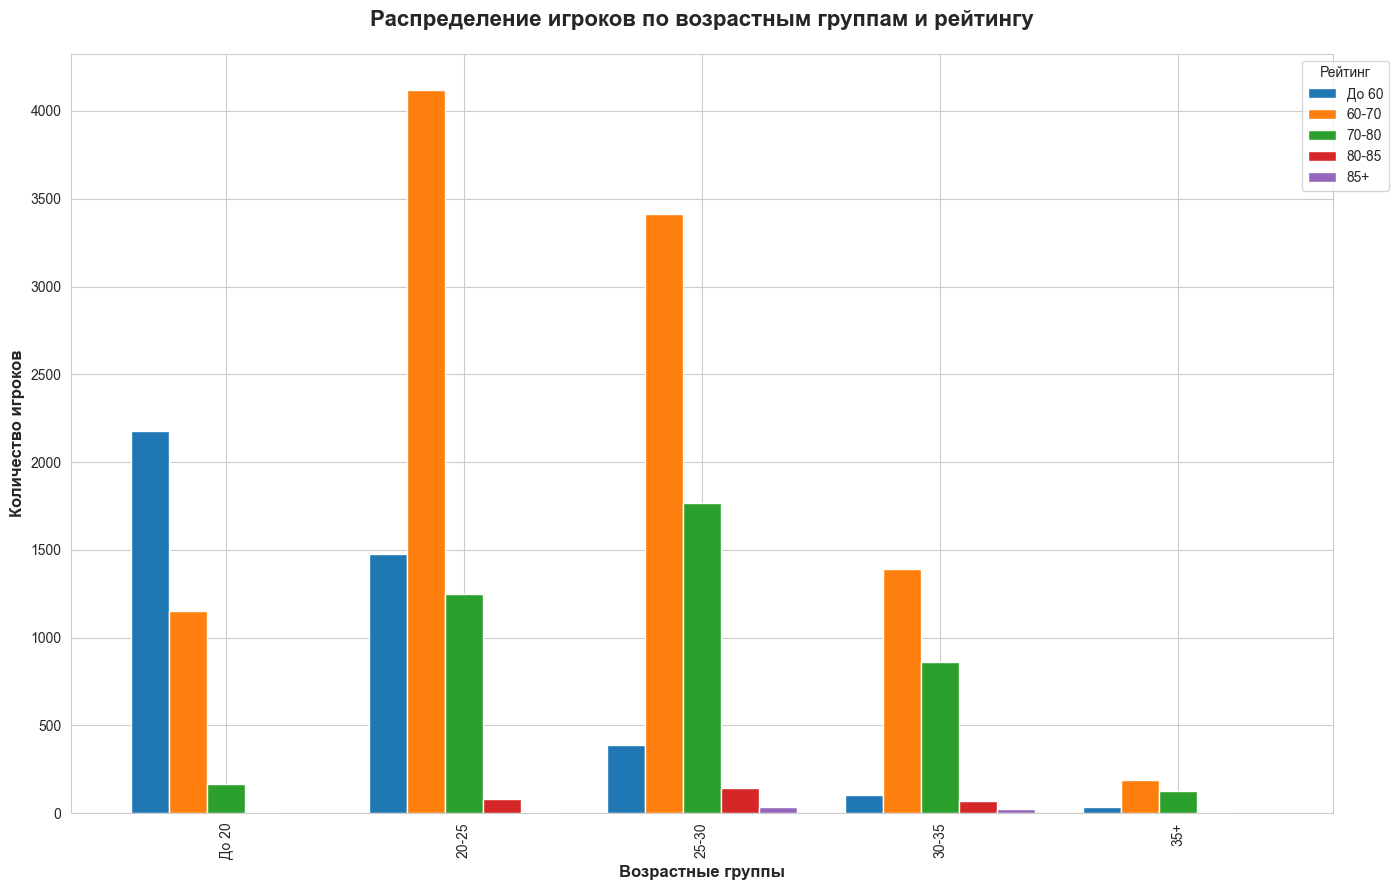

In [14]:
if df is not None:
    pivot_data = df.pivot_table(values='ova', index='age_group', columns='rating_group', aggfunc='count', fill_value=0)
    fig, ax = plt.subplots(figsize=(14, 9))
    pivot_data.plot(kind='bar', ax=ax, width=0.8)
    ax.set_title('Распределение игроков по возрастным группам и рейтингу', fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('Возрастные группы', fontsize=12, fontweight='bold')
    ax.set_ylabel('Количество игроков', fontsize=12, fontweight='bold')
    ax.legend(title='Рейтинг', bbox_to_anchor=(1.05, 1))
    plt.tight_layout()
    plt.savefig('age_rating_distribution.png', dpi=300)
    plt.show()

### 4.3. Корреляционная матрица ключевых навыков

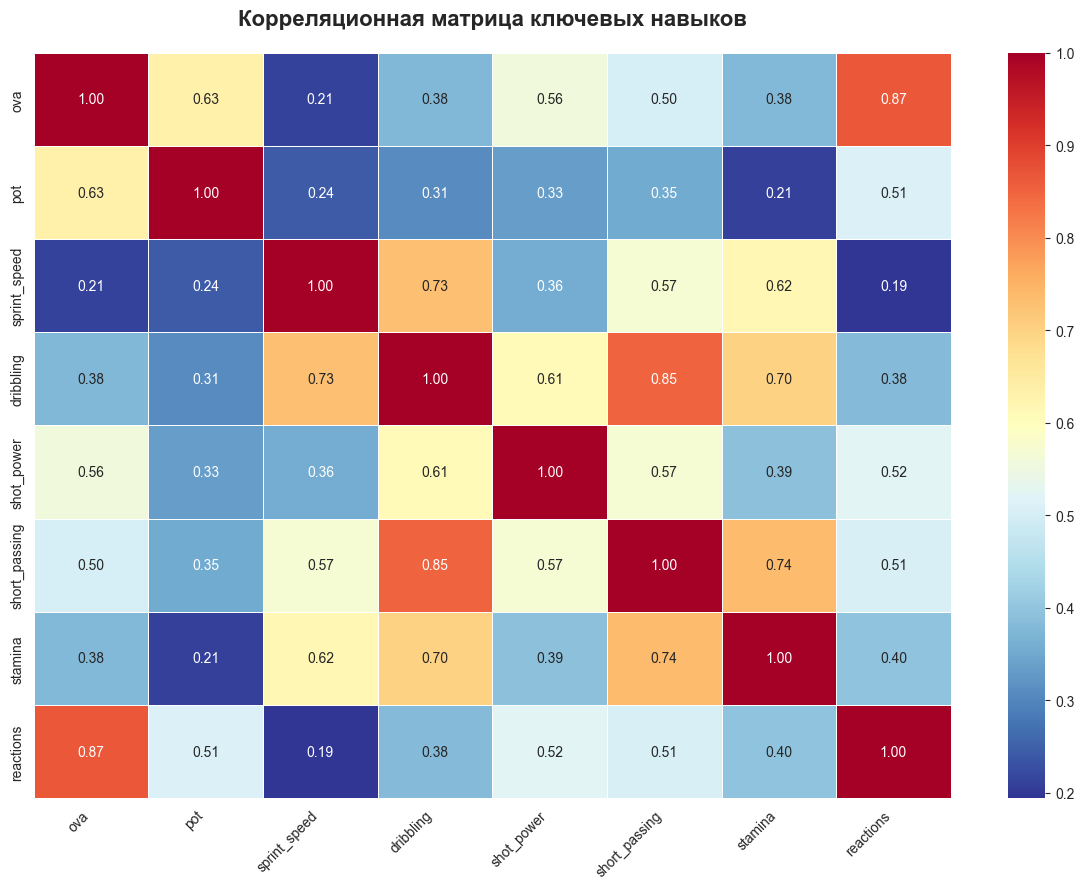

In [15]:
if df is not None:
    key_skills = ['ova', 'pot', 'sprint_speed', 'dribbling', 'shot_power', 'short_passing', 'stamina', 'reactions']
    key_skills = [col for col in key_skills if col in df.columns]
    correlation_matrix = df[key_skills].corr()
    
    plt.figure(figsize=(12, 9))
    sns.heatmap(correlation_matrix, annot=True, cmap='RdYlBu_r', fmt='.2f', linewidths=.5)
    plt.title('Корреляционная матрица ключевых навыков', fontsize=16, fontweight='bold', pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('correlation_heatmap.png', dpi=300)
    plt.show()

### 4.4. Распределение игроков по топ-10 национальностям

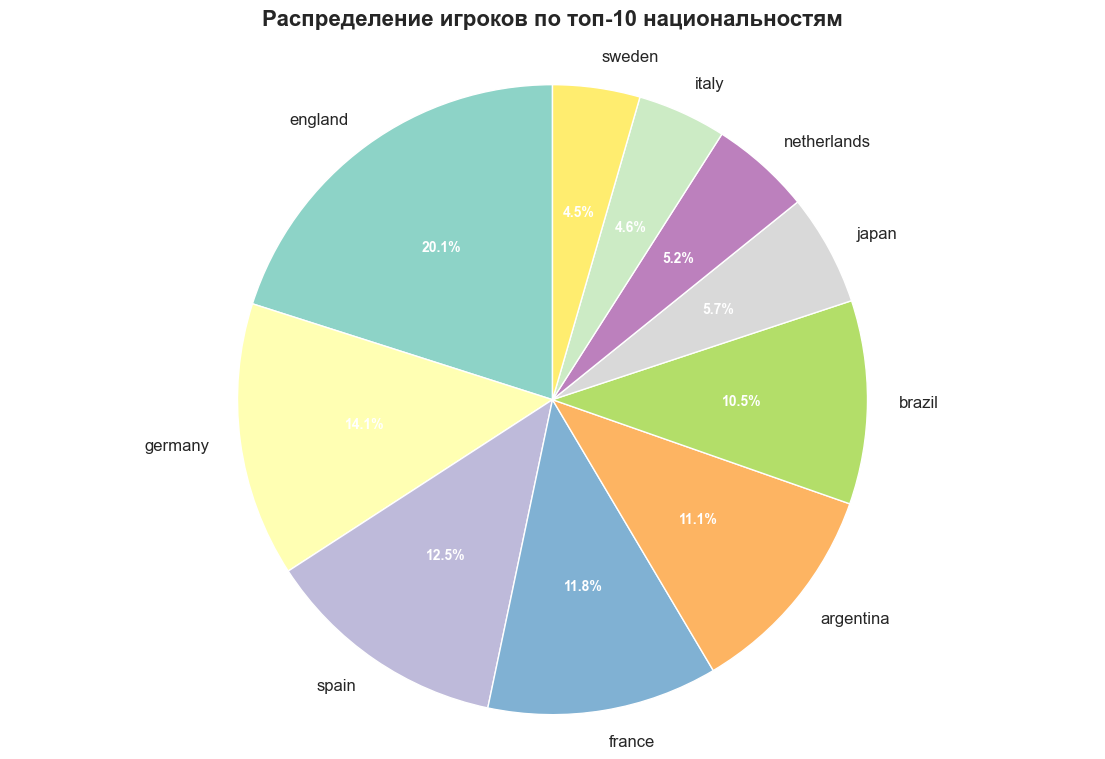

In [16]:
if df is not None:
    top_countries = df['nationality'].value_counts().head(10)
    fig, ax = plt.subplots(figsize=(14, 9))
    wedges, texts, autotexts = ax.pie(top_countries.values, labels=top_countries.index, 
                                      autopct='%1.1f%%', startangle=90,
                                      colors=plt.cm.Set3(np.linspace(0, 1, len(top_countries))))
    ax.set_title('Распределение игроков по топ-10 национальностям', fontsize=16, fontweight='bold', pad=20)
    plt.setp(autotexts, size=10, weight="bold", color="white")
    plt.setp(texts, size=12)
    plt.axis('equal')
    plt.savefig('nationality_distribution.png', dpi=300)
    plt.show()

### 4.5. Распределение рейтинга по возрастным группам (Box Plot)

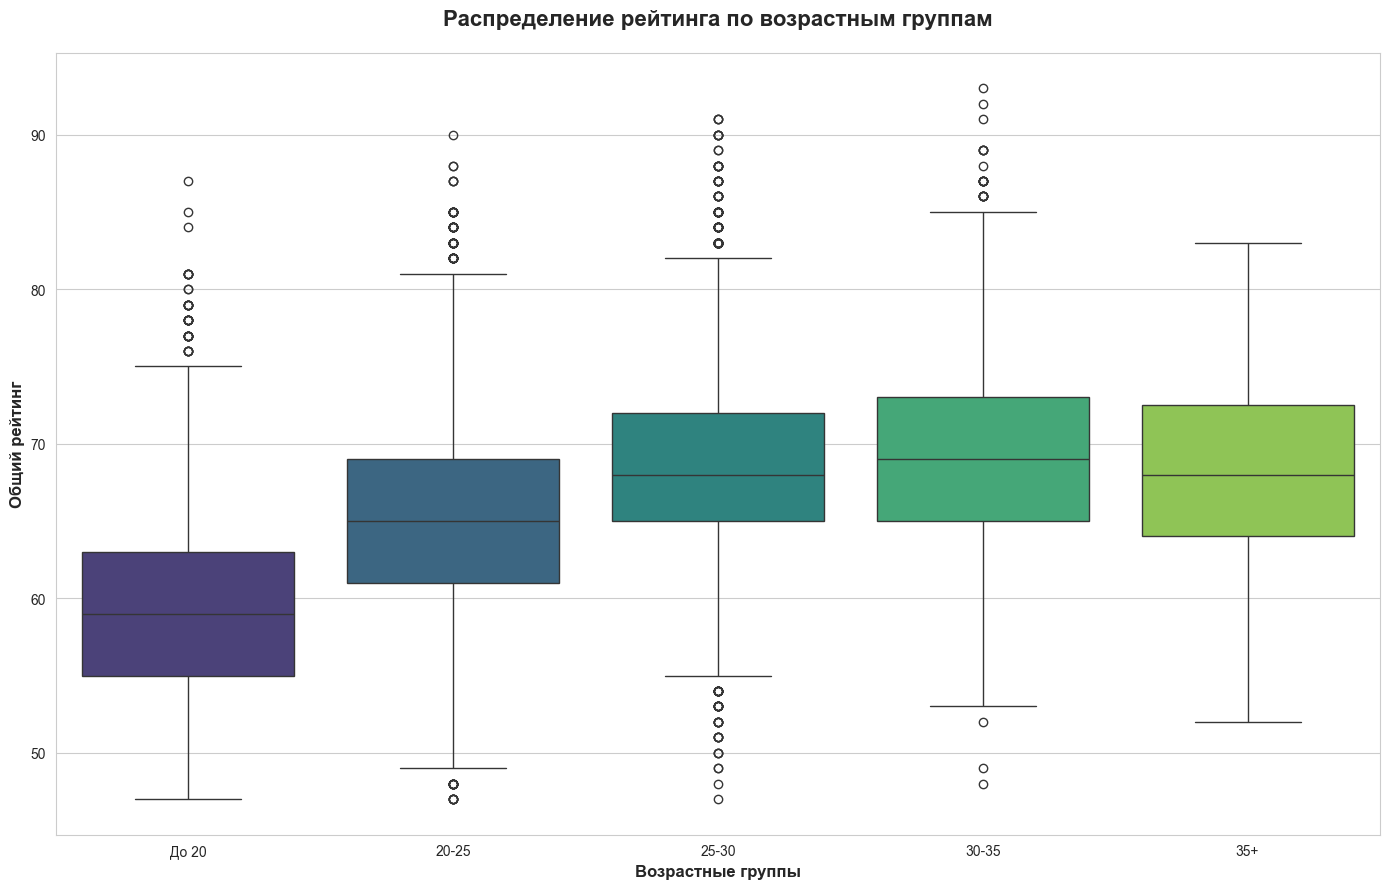

In [17]:
if df is not None:
    plt.figure(figsize=(14, 9))
    sns.boxplot(data=df, x='age_group', y='ova', palette='viridis')
    plt.title('Распределение рейтинга по возрастным группам', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Возрастные группы', fontsize=12, fontweight='bold')
    plt.ylabel('Общий рейтинг', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.savefig('rating_boxplot.png', dpi=300)
    plt.show()